# Treinamento do modelo

## 1 - import das bibliotecas e data set

Carregamos os arquivos processados e instanciamos as variáveis fundamentais que alimentarão o pipeline de treinamento e inferência:

* **`X_train` e `y_train`:** Representam, respectivamente, a matriz de features e o vetor alvo (classes) utilizados para ajustar os pesos dos modelos (*fit*).
* **`X_val` e `y_val`:** Conjunto de validação apartado, usado para medir a performance (*score*) e ajustar hiperparâmetros sem viciar o modelo.

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import contextlib
from tqdm.auto import tqdm
import math

# --- Bibliotecas para Distribuições Estatísticas ---
from scipy.stats import randint, uniform, loguniform

# --- Modelos (Removidos SVC e KNN por performance) ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

# --- Avaliação e Tuning ---
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve,
    auc,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

# 1. Carregamento e Preparação de Pastas
path_dados = '../data/'
path_models = '../models/'
folder_path = os.path.join(path_models, 'new_models')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

X_train = pd.read_csv(os.path.join(path_dados, 'X_train.csv'))
X_val = pd.read_csv(os.path.join(path_dados, 'X_val.csv'))
y_train = pd.read_csv(os.path.join(path_dados, 'y_train.csv')).values.ravel()
y_val = pd.read_csv(os.path.join(path_dados, 'y_val.csv')).values.ravel()

# Inicialização do dicionário global de resultados (executar apenas uma vez)
if 'all_results' not in locals():
    all_results = {}

print(f"Arquivos carregados.{X_train.shape[0]} amostras.")

c:\Users\Guilherme\anaconda3\envs\LIGIA_indv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Arquivos carregados.182276 amostras.


## 2 - Criação dos modelos para tunning

**Utilizamos a biblioteca tqdm para gerar barras de progresso visual durante o treinamento.**

In [ ]:
# --- BARRA DE PROGRESSO UNIVERSAL PARA SCIKIT-LEARN ---
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

print("✅ Ferramenta de barra de progresso carregada!")

✅ Ferramenta de barra de progresso carregada!


**Selecionamos seis arquiteturas diferentes para competir pela melhor performance na detecção de fraudes. A estratégia de treinamento segue os seguintes pilares:**

1.  **Algoritmos:** Testamos uma mistura de *Estatics Methods* (Logist Regression), *Ensemble Methods* (Random Forest, XGBoost, LightGBM, CatBoost) e *Deep Learning* (MLP/Neural Net).
2.  **Validação Cruzada Estratificada:** Usamos `StratifiedKFold (k=5)` para garantir que a proporção de fraudes seja mantida em todas as dobras de treino e teste.
3.  **Busca Aleatória (`RandomizedSearchCV`):** Em vez de testar todas as combinações (GridSearch), que seria inviável, exploramos espaços de hiperparâmetros aleatoriamente para encontrar o equilíbrio ótimo entre viés e variância.
4.  **Métrica de Decisão:** Otimizamos focando na métrica **ROC-AUC**, que avalia a capacidade global do modelo de distinguir classes.

### 2.1 - Logistic Regression

A Regressão Logística atua como nosso ponto de partida (*baseline*) linear. 
* **Estratégia:** Utilizamos o otimizador **SAGA**, que permite a aplicação da regularização **ElasticNet** (uma combinação híbrida entre L1 e L2). O parâmetro `class_weight='balanced'` é fundamental, ajustando inversamente os pesos das classes para dar muito mais importância aos erros cometidos na detecção de fraudes.
* **Hiperparâmetros:** A busca aleatória explora a intensidade da regularização (`C`) e o equilíbrio de mistura (`l1_ratio`). Isso permite que o modelo realize simultaneamente a seleção de variáveis (zerando coeficientes irrelevantes via L1) e o controle de magnitude (via L2), buscando a fronteira de decisão linear mais robusta possível.

In [ ]:
filename = os.path.join(folder_path, 'modelo_regressao_logistica.pkl')
name = 'Logistic_Regression'

if os.path.exists(filename):
    print(f"⏩ Modelo {name} já existe em '{filename}'! Carregando do disco...")
    model = joblib.load(filename)

else:
    print(f"⚙️ Arquivo não encontrado. Iniciando treinamento de {name}...")
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_iter = 30
    total_fits = n_iter * 5

    with tqdm_joblib(tqdm(desc=f"Treinando {name}", total=total_fits)) as progress_bar:
        search = RandomizedSearchCV(
            LogisticRegression(max_iter=5000, class_weight='balanced', solver='saga', random_state=42),
            param_distributions={
                'C': loguniform(1e-4, 1e2),
                'penalty': ['l1', 'l2', 'elasticnet'],
                'l1_ratio': uniform(0, 1)
            },
            n_iter=n_iter,
            cv=cv, 
            scoring='roc_auc', 
            n_jobs=-1, 
            random_state=42, 
            verbose=0
        )
        search.fit(X_train, y_train)
    
    # Extrai o melhor modelo
    model = search.best_estimator_
    
    # Salva imediatamente após treinar
    joblib.dump(model, filename)
    print(f"💾 Modelo treinado e salvo com sucesso em: {filename}")
    print(f"🌟 Melhores Parâmetros {name}: {search.best_params_}")


print(f"\n>>> Avaliando {name}...")
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

if 'all_results' not in globals(): all_results = {}

all_results[name] = {
    'model': model,
    'auc': roc_auc_score(y_val, y_prob),
    'acc': accuracy_score(y_val, y_pred),
    'prec': precision_score(y_val, y_pred),
    'rec': recall_score(y_val, y_pred),
    'f1': f1_score(y_val, y_pred)
}

print(f"✅ {name} finalizado! AUC: {all_results[name]['auc']:.4f}")


⏩ Modelo Logistic_Regression já existe em '../models/new_models\modelo_regressao_logistica.pkl'! Carregando do disco...

>>> Avaliando Logistic_Regression...
✅ Logistic_Regression finalizado! AUC: 0.9725


### 2.2 - Random Forest

O Random Forest atua como nosso modelo base robusto.
* **Estratégia:** Utiliza o parâmetro `class_weight='balanced'` para penalizar erros na classe minoritária (fraude).
* **Hiperparâmetros:** Focamos em controlar a profundidade (`max_depth`) e o número mínimo de amostras por folha (`min_samples_leaf`) para evitar que o modelo decore os dados de treino (*overfitting*).

In [13]:
name = 'Random_Forest'
filename = os.path.join(folder_path, 'modelo_random_forest.pkl')

if os.path.exists(filename):
    print(f"⏩ Modelo {name} já existe! Carregando do disco...")
    model = joblib.load(filename)
else:
    print(f"⚙️ Iniciando treinamento de {name}...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_iter = 30 
    total_fits = n_iter * 5

    with tqdm_joblib(tqdm(desc=f"Treinando {name}", total=total_fits)) as progress_bar:
        search = RandomizedSearchCV(
            RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1),
            param_distributions={
                'n_estimators': randint(100, 500),
                'max_depth': randint(5, 30),
                'min_samples_split': randint(5, 20),
                'min_samples_leaf': randint(2, 10),
                'max_features': ['sqrt', 'log2'],
                'bootstrap': [True, False]
            },
            n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train, y_train)
    
    model = search.best_estimator_
    joblib.dump(model, filename)
    print(f"💾 Modelo salvo em: {filename}")
    print(f"🌟 Melhores Parâmetros {name}: {search.best_params_}")

# Avaliação Comum
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
all_results[name] = {
    'model': model, 'auc': roc_auc_score(y_val, y_prob), 'acc': accuracy_score(y_val, y_pred),
    'prec': precision_score(y_val, y_pred), 'rec': recall_score(y_val, y_pred), 'f1': f1_score(y_val, y_pred)
}
tqdm.write(f"✅ {name} finalizado! AUC: {all_results[name]['auc']:.4f}\n")

⏩ Modelo Random_Forest já existe! Carregando do disco...
✅ Random_Forest finalizado! AUC: 0.9732



### 2.3 - CatBoost

O CatBoost foi configurado para explorar suas capacidades únicas de lidar com dados numéricos de forma robusta.
* **Estratégia de Pesos:** Diferente do XGBoost, aqui fixamos `auto_class_weights='Balanced'`, delegando ao algoritmo o cálculo ótimo dos pesos baseado na frequência das classes.
* **Quantização e Estabilidade:** A busca otimiza o `border_count` (que define a granularidade da discretização das features numéricas) e a `bagging_temperature` (que controla a aleatoriedade do bootstrap bayesiano), buscando um equilíbrio fino entre viés e variância.

In [14]:
name = 'CatBoost'
filename = os.path.join(folder_path, 'modelo_catboost.pkl')

if os.path.exists(filename):
    print(f"⏩ Modelo {name} já existe! Carregando do disco...")
    model = joblib.load(filename)
else:
    print(f"⚙️ Iniciando treinamento de {name}...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_iter = 100
    total_fits = n_iter * 5

    with tqdm_joblib(tqdm(desc=f"Treinando {name}", total=total_fits)) as progress_bar:
        search = RandomizedSearchCV(
            CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42),
            param_distributions={
                'iterations': randint(100, 1000),
                'depth': randint(4, 10),
                'learning_rate': loguniform(0.01, 0.3),
                'l2_leaf_reg': randint(1, 15),
                'border_count': randint(32, 255),
                'bagging_temperature': uniform(0, 1)
            },
            n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train, y_train)
    
    model = search.best_estimator_
    joblib.dump(model, filename)
    print(f"💾 Modelo salvo em: {filename}")
    print(f"🌟 Melhores Parâmetros {name}: {search.best_params_}")

# Avaliação
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
all_results[name] = {
    'model': model, 'auc': roc_auc_score(y_val, y_prob), 'acc': accuracy_score(y_val, y_pred),
    'prec': precision_score(y_val, y_pred), 'rec': recall_score(y_val, y_pred), 'f1': f1_score(y_val, y_pred)
}
tqdm.write(f"✅ {name} finalizado! AUC: {all_results[name]['auc']:.4f}\n")

⏩ Modelo CatBoost já existe! Carregando do disco...
✅ CatBoost finalizado! AUC: 0.9746



### 2.4 - XGBoost

Para o XGBoost, adotamos uma estratégia agressiva de regularização para combater o *overfitting* em dados desbalanceados.
* **Estratégia de Performance:** Utilizamos `tree_method='hist'`, que agrupa features contínuas em histogramas discretos, acelerando drasticamente o treino sem perda significativa de precisão.
* **Balanceamento Dinâmico:** O parâmetro `scale_pos_weight` não foi fixado, mas sim buscado num intervalo dinâmico (`ratio/2` a `ratio*1.5`), permitindo que o modelo encontre o peso ideal para a classe minoritária, em vez de impor um cálculo matemático rígido.
* **Regularização Dupla:** A busca inclui tanto regularização L1 (`reg_alpha`) quanto L2 (`reg_lambda`) e `gamma`, forçando o modelo a ser conservador na criação de novos nós.

In [15]:
name = 'XGBoost'
filename = os.path.join(folder_path, 'modelo_xgboost.pkl')

if os.path.exists(filename):
    print(f"⏩ Modelo {name} já existe! Carregando do disco...")
    model = joblib.load(filename)
else:
    print(f"⚙️ Iniciando treinamento de {name}...")
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_iter = 200
    total_fits = n_iter * 5
    
    # Cálculo do ratio para balanceamento (Negativos / Positivos)
    ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
    print(f"ℹ️ Ratio calculado para scale_pos_weight: {ratio:.2f}")

    with tqdm_joblib(tqdm(desc=f"Treinando {name}", total=total_fits)) as progress_bar:
        search = RandomizedSearchCV(
            XGBClassifier(
                objective='binary:logistic',
                eval_metric='aucpr', 
                random_state=42, 
                n_jobs=-1, 
                tree_method='hist'
            ),
            param_distributions={
                'n_estimators': randint(100, 1000),
                'learning_rate': loguniform(0.01, 0.3),
                'max_depth': randint(3, 10),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'gamma': uniform(0, 5),
                
                'scale_pos_weight': randint(int(ratio/2), int(ratio*1.5)),
                'min_child_weight': randint(1, 10),
                
                'reg_alpha': loguniform(1e-3, 10),
                'reg_lambda': loguniform(1e-3, 10)
            },
            n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train, y_train)
    
    model = search.best_estimator_
    joblib.dump(model, filename)
    print(f"💾 Modelo salvo em: {filename}")
    print(f"🌟 Melhores Parâmetros {name}: {search.best_params_}")

# Avaliação
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
all_results[name] = {
    'model': model, 'auc': roc_auc_score(y_val, y_prob), 'acc': accuracy_score(y_val, y_pred),
    'prec': precision_score(y_val, y_pred), 'rec': recall_score(y_val, y_pred), 'f1': f1_score(y_val, y_pred)
}
tqdm.write(f"✅ {name} finalizado! AUC: {all_results[name]['auc']:.4f}\n")

⏩ Modelo XGBoost já existe! Carregando do disco...
✅ XGBoost finalizado! AUC: 0.9742



### 2.5 - LightGBM

No LightGBM, a estratégia foca na estrutura da árvore e na estocasticidade para garantir generalização.
* **Controle de Complexidade:** Ao otimizar `num_leaves` em conjunto com `max_depth`, exploramos a característica *leaf-wise* (crescimento por folhas) do algoritmo, que é mais preciso mas propenso a overfitting se não controlado.
* **Amostragem Estocástica:** A busca por `feature_fraction` e `bagging_fraction` introduz aleatoriedade na seleção de colunas e linhas a cada iteração, uma técnica poderosa para criar ensembles mais diversos e robustos.
* **Peso de Classe:** Aqui, testamos uma faixa ampla de `scale_pos_weight` (10 a 500), dando liberdade total ao modelo para decidir o quão agressivamente deve penalizar erros na classe de fraude.

In [16]:
name = 'LightGBM'
filename = os.path.join(folder_path, 'modelo_lightgbm.pkl')

if os.path.exists(filename):
    print(f"⏩ Modelo {name} já existe! Carregando do disco...")
    model = joblib.load(filename)
else:
    print(f"⚙️ Iniciando treinamento de {name}...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_iter = 200
    total_fits = n_iter * 5

    with tqdm_joblib(tqdm(desc=f"Treinando {name}", total=total_fits)) as progress_bar:
        search = RandomizedSearchCV(
            LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1),
            param_distributions={
                'n_estimators': randint(100, 1000),
                'learning_rate': loguniform(0.01, 0.3),
                'num_leaves': randint(20, 128),
                'max_depth': randint(5, 20),
                'min_child_samples': randint(10, 100),
                'scale_pos_weight': randint(10, 500), 
                'feature_fraction': uniform(0.6, 0.4),
                'bagging_fraction': uniform(0.6, 0.4),
                'bagging_freq': randint(1, 10)
            },
            n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train, y_train)
    
    model = search.best_estimator_
    joblib.dump(model, filename)
    print(f"💾 Modelo salvo em: {filename}")
    print(f"🌟 Melhores Parâmetros {name}: {search.best_params_}")

# Avaliação
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
all_results[name] = {
    'model': model, 'auc': roc_auc_score(y_val, y_prob), 'acc': accuracy_score(y_val, y_pred),
    'prec': precision_score(y_val, y_pred), 'rec': recall_score(y_val, y_pred), 'f1': f1_score(y_val, y_pred)
}
tqdm.write(f"✅ {name} finalizado! AUC: {all_results[name]['auc']:.4f}\n")

⏩ Modelo LightGBM já existe! Carregando do disco...
✅ LightGBM finalizado! AUC: 0.9750



### 2.6 - Neural net

Nossa abordagem de Deep Learning busca encontrar a arquitetura de rede ideal para capturar não-linearidades complexas.
* **Busca de Arquitetura:** Testamos diferentes topologias (`hidden_layer_sizes`), variando desde redes rasas e largas até redes profundas e afuniladas (ex: 64 -> 32 neurônios), juntamente com funções de ativação `relu` e `tanh`.
* **Early Stopping com Paciência:** Configuramos `early_stopping=True` com uma paciência de 15 épocas (`n_iter_no_change=15`). Isso permite que treinemos por até 800 épocas, mas interrompemos o processo assim que a rede para de aprender, economizando tempo e evitando a memorização do ruído (overfitting).

In [17]:
name = 'Neural_net'
filename = os.path.join(folder_path, 'modelo_neural_net.pkl')

if os.path.exists(filename):
    print(f"⏩ Modelo {name} já existe! Carregando do disco...")
    model = joblib.load(filename)
else:
    print(f"⚙️ Iniciando treinamento de {name}...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_iter = 400
    total_fits = n_iter * 5

    with tqdm_joblib(tqdm(desc=f"Treinando {name}", total=total_fits)) as progress_bar:
        search = RandomizedSearchCV(
            MLPClassifier(max_iter=800, early_stopping=True, n_iter_no_change=15, random_state=42),
            param_distributions={
                'hidden_layer_sizes': [(50,), (100,), (100, 50), (64, 32)],
                'activation': ['relu', 'tanh'],
                'alpha': loguniform(1e-4, 1e-1),
                'learning_rate_init': loguniform(1e-4, 1e-1),
                'solver': ['adam']
            },
            n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X_train, y_train)
    
    model = search.best_estimator_
    joblib.dump(model, filename)
    print(f"💾 Modelo salvo em: {filename}")
    print(f"🌟 Melhores Parâmetros {name}: {search.best_params_}")

# Avaliação
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
all_results[name] = {
    'model': model, 'auc': roc_auc_score(y_val, y_prob), 'acc': accuracy_score(y_val, y_pred),
    'prec': precision_score(y_val, y_pred), 'rec': recall_score(y_val, y_pred), 'f1': f1_score(y_val, y_pred)
}
tqdm.write(f"✅ {name} finalizado! AUC: {all_results[name]['auc']:.4f}\n")

⏩ Modelo Neural_net já existe! Carregando do disco...
✅ Neural_net finalizado! AUC: 0.9762



### 2.7 - Mostrar hiperparametros escolhidos em cada modelo

In [ ]:
def extrair_hiperparametros(caminho_modelo, nome_modelo):
    """Carrega o modelo e imprime os hiperparâmetros essenciais."""
    print("\n" + "="*65)
    print(f"🧠 HIPERPARÂMETROS: {nome_modelo.upper()}")
    print("="*65)
    
    if not os.path.exists(caminho_modelo):
        print(f"❌ Ficheiro não encontrado no caminho: {caminho_modelo}")
        return
        
    try:
        modelo = joblib.load(caminho_modelo)
        
        if hasattr(modelo, 'best_params_'):
            print("✅ Histórico de otimização encontrado! Os melhores parâmetros foram:\n")
            for parametro, valor in modelo.best_params_.items():
                print(f"  • {parametro}: {valor}")
                
        else:
            print("✅ Estimador final carregado. Configurações:\n")
            parametros = modelo.get_params()
            
            params_para_ignorar = ['verbose', 'n_jobs', 'random_state', 'class_weight']
            
            for parametro, valor in parametros.items():
                if parametro not in params_para_ignorar and valor is not None:
                    print(f"  • {parametro}: {valor}")
                    
    except Exception as e:
        print(f"⚠️ Erro ao tentar extrair dados de {nome_modelo}: {e}")

# EXECUÇÃO EM LOTE PARA TODOS OS MODELOS

dicionario_modelos = {
    'Neural_net': '../models/new_models/modelo_neural_net.pkl',
    'XGBoost': '../models/new_models/modelo_xgboost.pkl',
    'CatBoost': '../models/new_models/modelo_catboost.pkl',
    'LightGBM': '../models/new_models/modelo_lightgbm.pkl',
    'Random_Forest': '../models/new_models/modelo_random_forest.pkl',
    'Logistic_Regression': '../models/new_models/modelo_regressao_logistica.pkl'
}

for nome, caminho in dicionario_modelos.items():
    extrair_hiperparametros(caminho, nome)


🧠 HIPERPARÂMETROS: NEURAL_NET
✅ Estimador final carregado. Configurações:

  • activation: tanh
  • alpha: 0.00011727009450102256
  • batch_size: auto
  • beta_1: 0.9
  • beta_2: 0.999
  • early_stopping: True
  • epsilon: 1e-08
  • hidden_layer_sizes: (100, 50)
  • learning_rate: constant
  • learning_rate_init: 0.006847920095574782
  • max_fun: 15000
  • max_iter: 500
  • momentum: 0.9
  • n_iter_no_change: 10
  • nesterovs_momentum: True
  • power_t: 0.5
  • shuffle: True
  • solver: adam
  • tol: 0.0001
  • validation_fraction: 0.1
  • warm_start: False

🧠 HIPERPARÂMETROS: XGBOOST
✅ Estimador final carregado. Configurações:

  • objective: binary:logistic
  • colsample_bytree: 0.8105996776615124
  • enable_categorical: False
  • eval_metric: aucpr
  • gamma: 0.5615217220560959
  • learning_rate: 0.0100882747893254
  • max_depth: 8
  • min_child_weight: 6
  • missing: nan
  • n_estimators: 376
  • reg_alpha: 3.4421187846732457
  • reg_lambda: 0.008171825567718654
  • scale_pos_weig

## 3 - Comparação entre os modelos


📋 TABELA DE PERFORMANCE DOS MODELOS


,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
1,Neural_net,0.976191,0.999320,0.833333,0.759494,0.794702
2,LightGBM,0.975047,0.999495,0.924242,0.772152,0.841379
3,CatBoost,0.974620,0.999342,0.826667,0.784810,0.805195
4,XGBoost,0.974171,0.999144,0.727273,0.810127,0.766467
5,Random_Forest,0.973245,0.999078,0.698925,0.822785,0.755814
6,Logistic_Regression,0.972505,0.981215,0.073546,0.848101,0.135354



🏆 O MODELO CAMPEÃO FOI SALVO: Neural_net
📊 AUC: 0.97619 | F1: 0.79470
✅ As variáveis 'best_model_name' e 'best_model_obj' foram atualizadas!

📈 COMPARAÇÃO VISUAL: CURVAS ROC


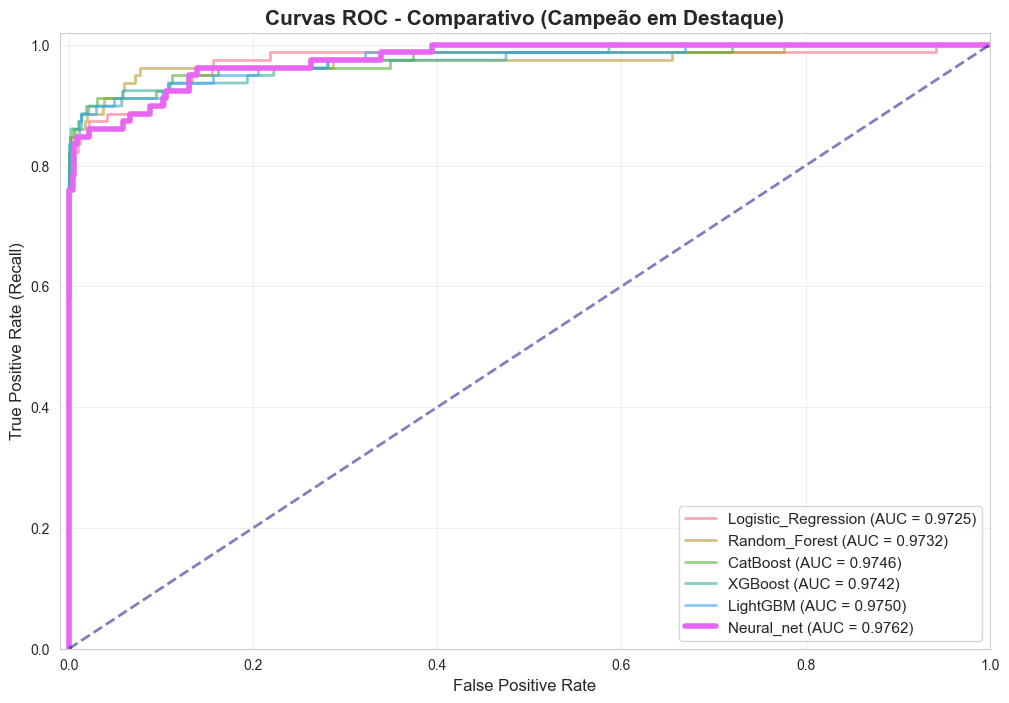


🧩 DETALHE DOS ERROS: MATRIZES DE CONFUSÃO


c:\Users\Guilherme\anaconda3\envs\LIGIA_indv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\Guilherme\anaconda3\envs\LIGIA_indv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


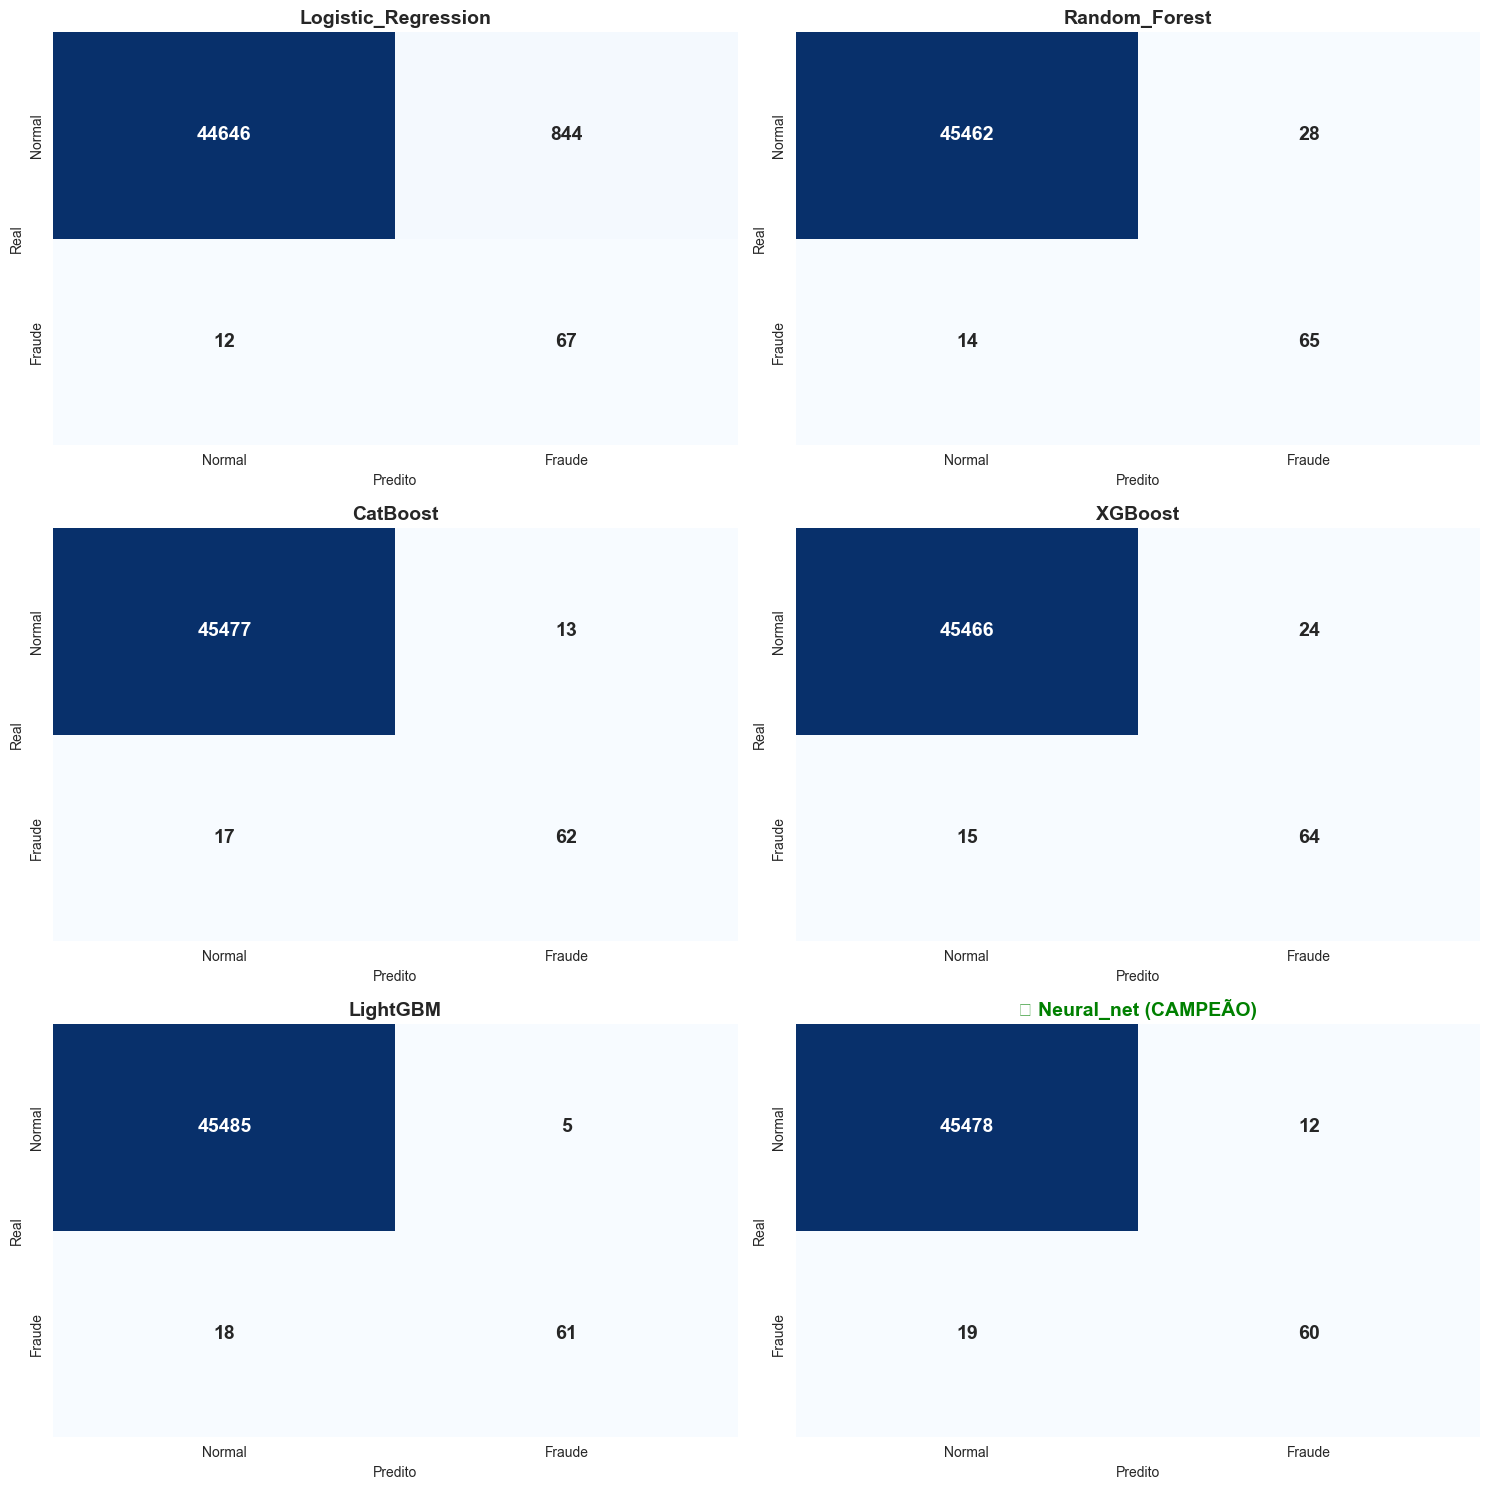

In [ ]:
sns.set_style("whitegrid")

if not all_results:
    print("❌ Nenhum modelo treinado. Rode os treinamentos primeiro!")
else:
    final_list = []
    for model_name, metrics in all_results.items():
        final_list.append({
            'Modelo': model_name,
            'ROC-AUC': metrics['auc'],
            'Accuracy': metrics['acc'],
            'Precision': metrics['prec'],
            'Recall': metrics['rec'],
            'F1-Score': metrics['f1']
        })

    # Ordena pelo AUC (Do maior para o menor)
    ranking_df = pd.DataFrame(final_list).sort_values(by='ROC-AUC', ascending=False)
    ranking_df = ranking_df.reset_index(drop=True)
    ranking_df.index += 1 

    print("\n" + "="*60)
    print("📋 TABELA DE PERFORMANCE DOS MODELOS")
    print("="*60)
    
    display(ranking_df)

    # melhor AUC
    best_row = ranking_df.iloc[0]
    
    # Salva o NOME e o OBJETO do modelo nas variáveis globais
    best_model_name = best_row['Modelo']
    best_model_obj = all_results[best_model_name]['model']

    joblib.dump(best_model_obj, '../models/best_model_fraud.pkl')
    print(f"\n🏆 \033[1mO MODELO CAMPEÃO FOI SALVO:\033[0m {best_model_name}")
    print(f"📊 AUC: {best_row['ROC-AUC']:.5f} | F1: {best_row['F1-Score']:.5f}")
    print("✅ As variáveis 'best_model_name' e 'best_model_obj' foram atualizadas!")

    # 2. CURVA ROC COMPARATIVA

    print("\n" + "="*60)
    print("📈 COMPARAÇÃO VISUAL: CURVAS ROC")
    print("="*60)
    
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("husl", len(all_results))

    for i, (name, metrics) in enumerate(all_results.items()):
        model = metrics['model']
        y_prob = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Destaca o campeão com uma linha mais grossa
        lw = 4 if name == best_model_name else 2
        alpha = 1.0 if name == best_model_name else 0.6
        
        plt.plot(fpr, tpr, color=colors[i], lw=lw, alpha=alpha,
                 label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('Curvas ROC - Comparativo (Campeão em Destaque)', fontsize=15, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show() 

    # 3. MATRIZES DE CONFUSÃO
    print("\n" + "="*60)
    print("🧩 DETALHE DOS ERROS: MATRIZES DE CONFUSÃO")
    print("="*60)
    
    n_models = len(all_results)
    cols = 2
    rows = math.ceil(n_models / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, (name, metrics) in enumerate(all_results.items()):
        model = metrics['model']
        ax = axes[i]
        
        y_pred = model.predict(X_val)
        cm = confusion_matrix(y_val, y_pred)
        
        if name == best_model_name:
            plt.setp(ax.spines.values(), color='green', linewidth=3)
            ax.set_title(f"🏆 {name} (CAMPEÃO)", fontsize=14, fontweight='bold', color='green')
        else:
            ax.set_title(f"{name}", fontsize=14, fontweight='bold')

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    ax=ax, annot_kws={"size": 14, "weight": "bold"})
        
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')
        ax.set_xticklabels(['Normal', 'Fraude'])
        ax.set_yticklabels(['Normal', 'Fraude'])

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()